In [1]:
import numpy as np
#from lib.cae import ConvAutoEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, average_precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

In [2]:
data = np.load('../data/data.npy')
meta = np.load('../data/meta.npy')
print(f'data = {data.shape}')
print(f'meta = {meta.shape}')

data = (1845, 21, 77)
meta = (1845, 3)


In [140]:
X = data[:,:,:,np.newaxis]
Y = meta[:,2][:,np.newaxis].astype(int)

In [141]:
shape = X.shape
std = StandardScaler().fit(X.reshape(-1,1))
X = std.transform(X.reshape(-1,1)).reshape(shape)

In [142]:
G = meta[:,0]
print(G.shape, len(np.unique(G)))

(1845,) 17


In [143]:
X,Y,G = shuffle(X,Y,G)

In [144]:
X = np.delete(X, 0, 1)
X.shape

(1845, 20, 77, 1)

In [145]:
X = np.delete(X, 0, 2)
X.shape

(1845, 20, 76, 1)

In [146]:
cnn_input = X.shape[1:]
cnn_output = 2 #Y.shape[1]
batch_size = 32

print(f"cnn_input  = {cnn_input}")
print(f"cnn_output = {cnn_output}")
print(f"batch_size = {batch_size}")

cnn_input  = (20, 76, 1)
cnn_output = 2
batch_size = 32


In [147]:
results = np.append(Y, np.zeros_like(Y), axis = 1)
results = np.append(results, np.zeros_like(Y), axis = 1).astype(float)
results.shape

(1845, 3)

In [148]:
x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, Y, G, test_size = 0.25, random_state = 31)

In [163]:
"""
An implementation of a convolutional autoencoder (CAE) using Keras.
Jason M. Manley, 2018
jmanley@rockefeller.edu
"""

import os
import keras
import numpy as np

class ConvAutoEncoder:

    def __init__(self, input_shape, output_dim, filters=[32, 64, 128, 256],
                 kernel=(3,3), stride=(1,1), strideundo=2, pool=(2,2),
                 optimizer="adamax", lossfn="mse"):
        # For now, assuming input_shape is mxnxc, and m,n are multiples of 2.

        self.input_shape = input_shape
        self.output_dim  = output_dim

        # define encoder architecture
        self.encoder = keras.models.Sequential()
        self.encoder.add(keras.layers.InputLayer(input_shape))
        for i in range(len(filters)):
            self.encoder.add(keras.layers.Conv2D(filters=filters[i], kernel_size=kernel, 
                                                 strides=stride, activation='elu', padding='same'))
            self.encoder.add(keras.layers.MaxPooling2D(pool_size=pool))
        self.encoder.add(keras.layers.Flatten())
        self.encoder.add(keras.layers.Dense(output_dim))

        # define decoder architecture
        self.decoder = keras.models.Sequential()
        self.decoder.add(keras.layers.InputLayer((output_dim,)))
        
        self.decoder.add(keras.layers.Dense(int(input_shape[0]/(2**(len(filters)))) *
                                               int(input_shape[1]/(2**(len(filters)))) * filters[len(filters)-1]))
        self.decoder.add(keras.layers.Reshape((int(input_shape[0]/(2**(len(filters)))),
                                               int(input_shape[1]/(2**(len(filters)))), filters[len(filters)-1])))
        for i in range(1,len(filters)):
            self.decoder.add(keras.layers.Conv2DTranspose(filters=filters[len(filters)-i], kernel_size=kernel, 
                                                          strides=strideundo, activation='elu', padding='same'))
        self.decoder.add(    keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel, 
                                                          strides=strideundo, activation=None,  padding='same'))

        # compile model
        input         = keras.layers.Input(input_shape)
        code          = self.encoder(input)
        reconstructed = self.decoder(code)

        self.ae = keras.models.Model(inputs=input, outputs=reconstructed)
        self.ae.compile(optimizer=optimizer, loss=lossfn)


    def fit(self, train, test, epochs=25, callbacks=[keras.callbacks.BaseLogger()]):

        self.ae.fit(x=train, y=train, epochs=epochs, validation_data=[test, test],
                    callbacks=callbacks)

        self.mse = self.ae.evaluate(test, test)
        print('CAE MSE on validation data: ', self.mse)


    def save_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.save_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.save_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def load_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.load_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.load_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def encode(self, input):
        return self.encoder.predict(input)


    def decode(self, codes):
        return self.decoder.predict(codes)

In [164]:
cae = ConvAutoEncoder(input_shape = (x_train.shape[1], x_train.shape[2],1), output_dim = 10, 
                      filters = [32], pool = (2,2))
print(cnn_input)
cae.encoder.summary()
cae.decoder.summary()
cae.ae.summary()

(20, 76, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 76, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 38, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12160)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                121610    
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12160)             133760    
__________________________________________________________

In [166]:
cae.fit(X, X, epochs = 500)
cae.save_weights()

Train on 1845 samples, validate on 1845 samples
Epoch 1/500
1845/1845 [==============================] - 1s 273us/step - loss: 0.0520 - val_loss: 0.0514
Epoch 2/500
1845/1845 [==============================] - 1s 313us/step - loss: 0.0519 - val_loss: 0.0514
Epoch 3/500
1845/1845 [==============================] - 1s 313us/step - loss: 0.0520 - val_loss: 0.0515
Epoch 4/500
1845/1845 [==============================] - 1s 313us/step - loss: 0.0521 - val_loss: 0.0516
Epoch 5/500
1845/1845 [==============================] - 1s 312us/step - loss: 0.0523 - val_loss: 0.0515
Epoch 6/500
1845/1845 [==============================] - 1s 312us/step - loss: 0.0521 - val_loss: 0.0515
Epoch 7/500
1845/1845 [==============================] - 1s 312us/step - loss: 0.0524 - val_loss: 0.0516
Epoch 8/500
1845/1845 [==============================] - 1s 312us/step - loss: 0.0521 - val_loss: 0.0516
Epoch 9/500
1845/1845 [==============================] - 1s 313us/step - loss: 0.0519 - val_loss: 0.0514
Epoch 1

Epoch 78/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0520 - val_loss: 0.0518
Epoch 79/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0522 - val_loss: 0.0519
Epoch 80/500
1845/1845 [==============================] - 0s 192us/step - loss: 0.0525 - val_loss: 0.0516
Epoch 81/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0518 - val_loss: 0.0515
Epoch 82/500
1845/1845 [==============================] - 0s 193us/step - loss: 0.0518 - val_loss: 0.0514
Epoch 83/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0518 - val_loss: 0.0514
Epoch 84/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0519 - val_loss: 0.0514
Epoch 85/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0519 - val_loss: 0.0514
Epoch 86/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0518 - val_loss: 0.0515
Epoch 87/500
1845/1845 [======================

Epoch 155/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0520 - val_loss: 0.0523
Epoch 156/500
1845/1845 [==============================] - 0s 197us/step - loss: 0.0519 - val_loss: 0.0514
Epoch 157/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0517 - val_loss: 0.0514
Epoch 158/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0519 - val_loss: 0.0521
Epoch 159/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0521 - val_loss: 0.0516
Epoch 160/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0520 - val_loss: 0.0517
Epoch 161/500
1845/1845 [==============================] - 0s 197us/step - loss: 0.0520 - val_loss: 0.0516
Epoch 162/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0521 - val_loss: 0.0516
Epoch 163/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0519 - val_loss: 0.0515
Epoch 164/500
1845/1845 [============

1845/1845 [==============================] - 0s 196us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 308/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0517 - val_loss: 0.0514
Epoch 309/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 310/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 311/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0518 - val_loss: 0.0513
Epoch 312/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0519 - val_loss: 0.0516
Epoch 313/500
1845/1845 [==============================] - 0s 197us/step - loss: 0.0520 - val_loss: 0.0518
Epoch 314/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0520 - val_loss: 0.0514
Epoch 315/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0518 - val_loss: 0.0512
Epoch 316/500
1845/1845 [==========================

1845/1845 [==============================] - 0s 195us/step - loss: 0.0521 - val_loss: 0.0514
Epoch 460/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 461/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 462/500
1845/1845 [==============================] - 0s 197us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 463/500
1845/1845 [==============================] - 0s 192us/step - loss: 0.0518 - val_loss: 0.0517
Epoch 464/500
1845/1845 [==============================] - 0s 195us/step - loss: 0.0520 - val_loss: 0.0515
Epoch 465/500
1845/1845 [==============================] - 0s 196us/step - loss: 0.0519 - val_loss: 0.0513
Epoch 466/500
1845/1845 [==============================] - 0s 197us/step - loss: 0.0518 - val_loss: 0.0513
Epoch 467/500
1845/1845 [==============================] - 0s 194us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 468/500
1845/1845 [==========================

In [167]:
X_codes = cae.encode(X)

In [168]:
from sklearn.manifold import TSNE
X_codes_embedded = TSNE(n_components = 2).fit_transform(X_codes)

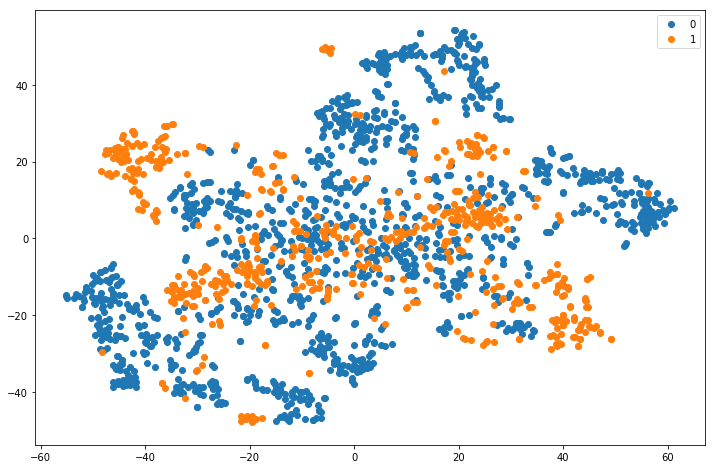

In [169]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax = plt.subplots()
m = np.squeeze(Y) == 0
plt.scatter(X_codes_embedded[m][:,0], X_codes_embedded[m][:,1], label = "0")
plt.scatter(X_codes_embedded[np.invert(m)][:,0], X_codes_embedded[np.invert(m)][:,1], label = "1")
plt.legend()
plt.show()

In [170]:
from sklearn.linear_model import LinearRegression

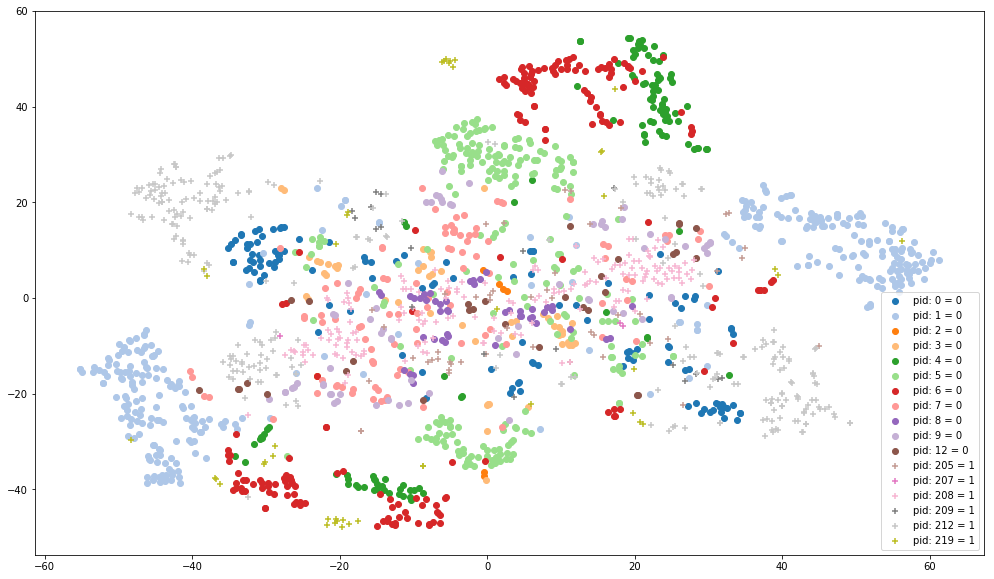

In [171]:
plt.rcParams['figure.figsize'] = (17, 10)
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab20')
markers = ['o','+']
linesty = ['-','--']
x_line = np.reshape(np.arange(-50,50,1),(100,1))
for i, g in enumerate(np.unique(G)):
    a = X_codes_embedded[G == g]
    c = np.max(Y[G == g])
    plt.scatter(a[:,0], a[:,1], label = f'pid: {g:.0f} = {c}', c = [cmap.colors[i]], marker = markers[c])
    #clf = LinearRegression().fit(a[:,0][:,np.newaxis],a[:,1])
    #y_line = clf.predict(x_line)
    #plt.plot(x_line, y_line, linesty[c], c = cmap.colors[i])
plt.legend()
#plt.ylim(-50,50)
plt.show()

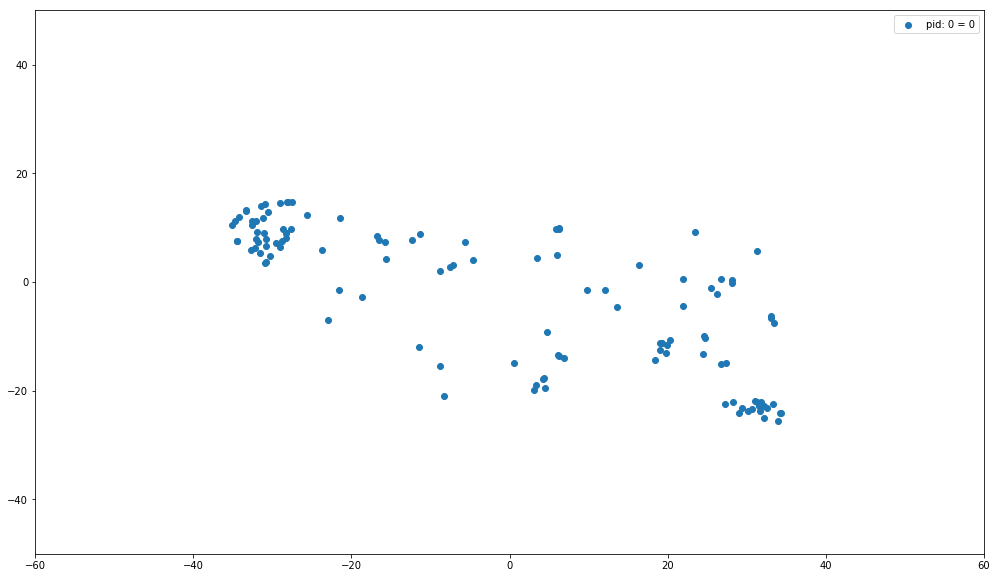

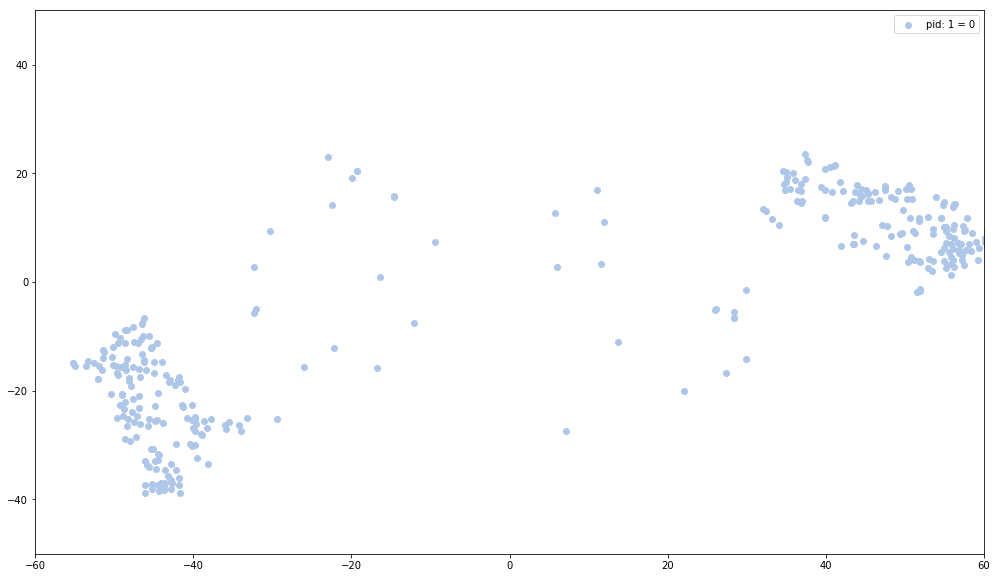

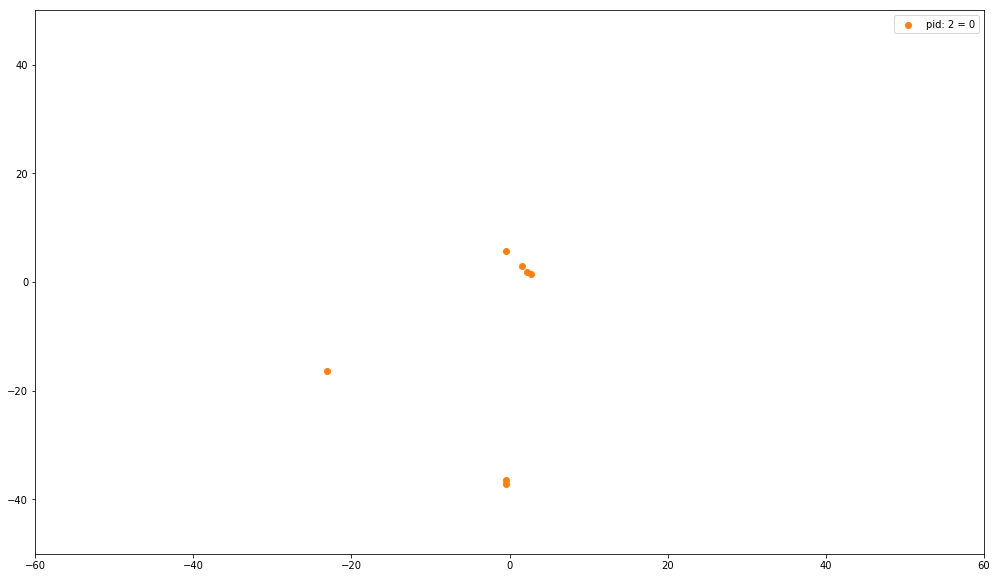

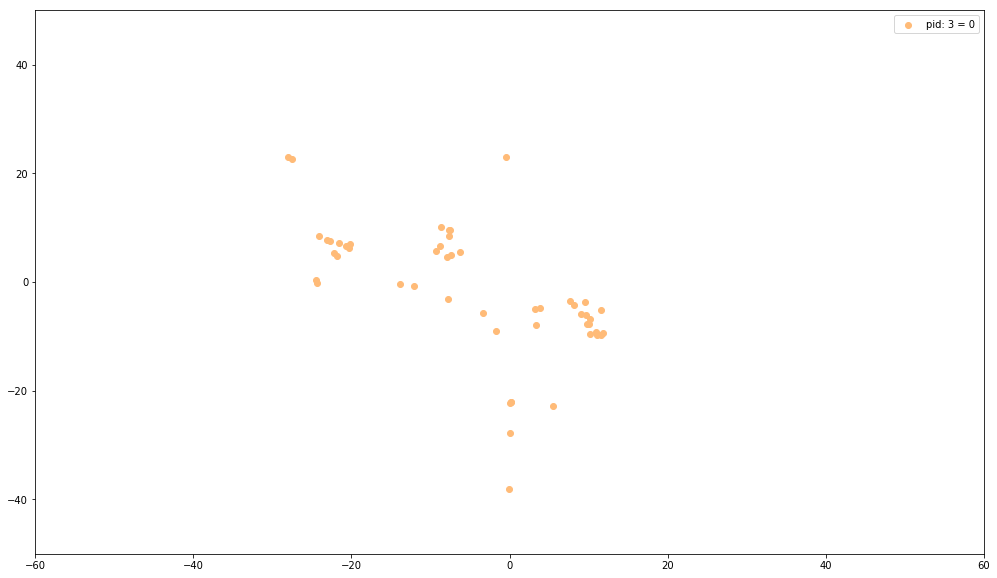

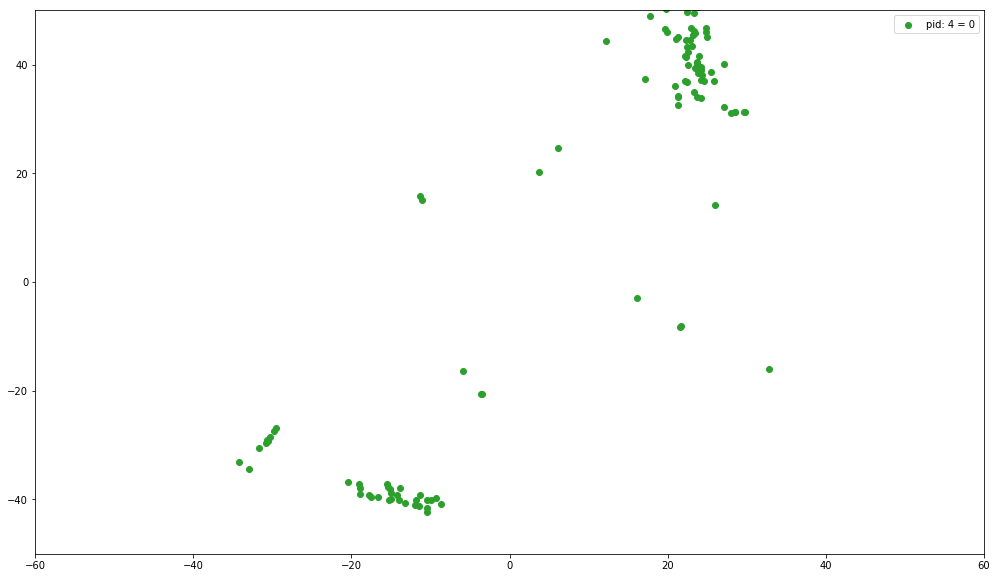

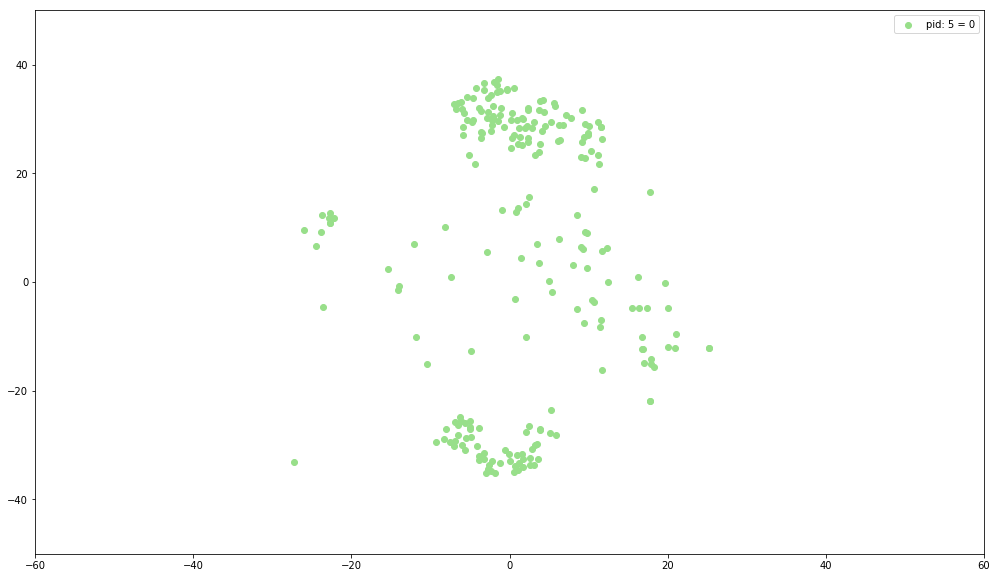

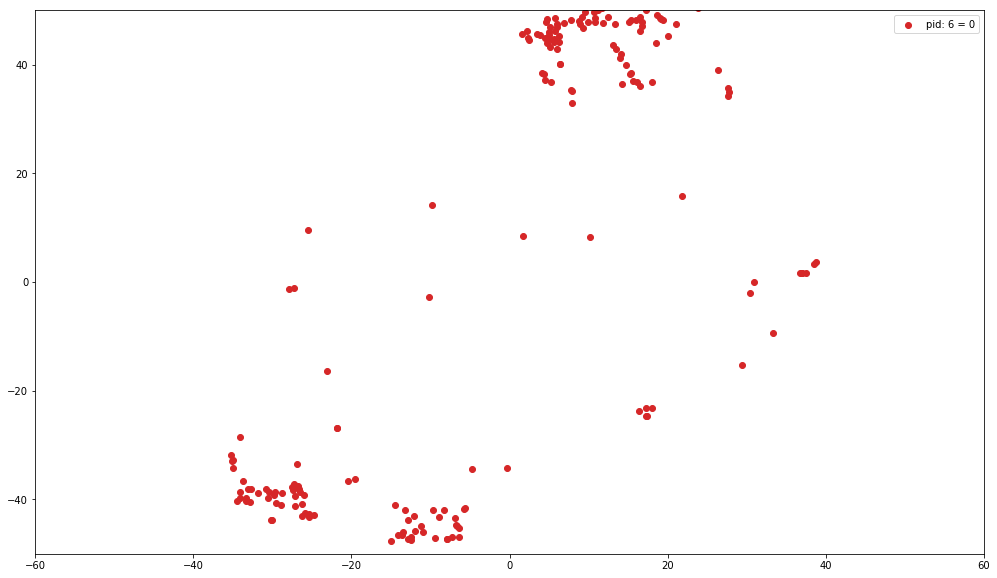

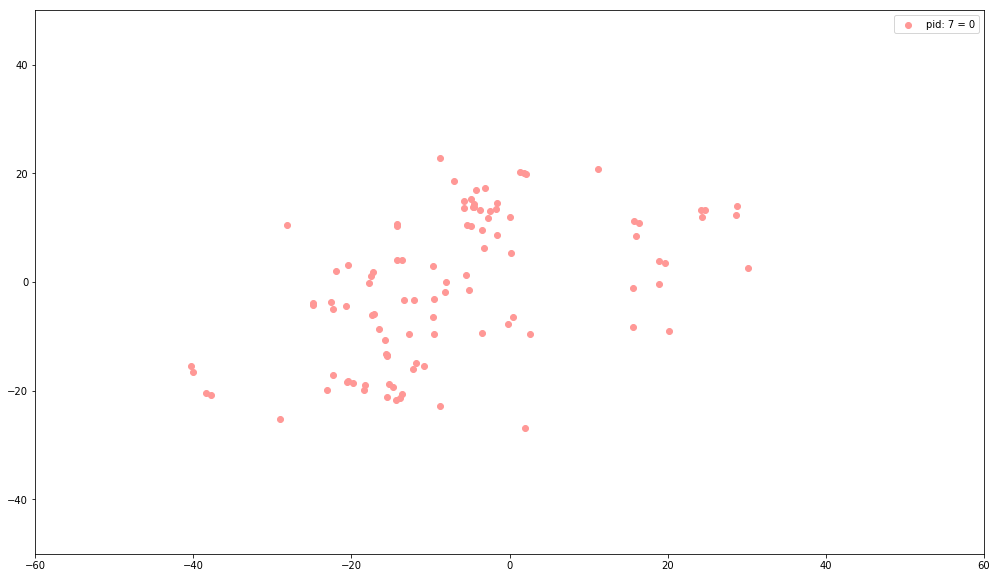

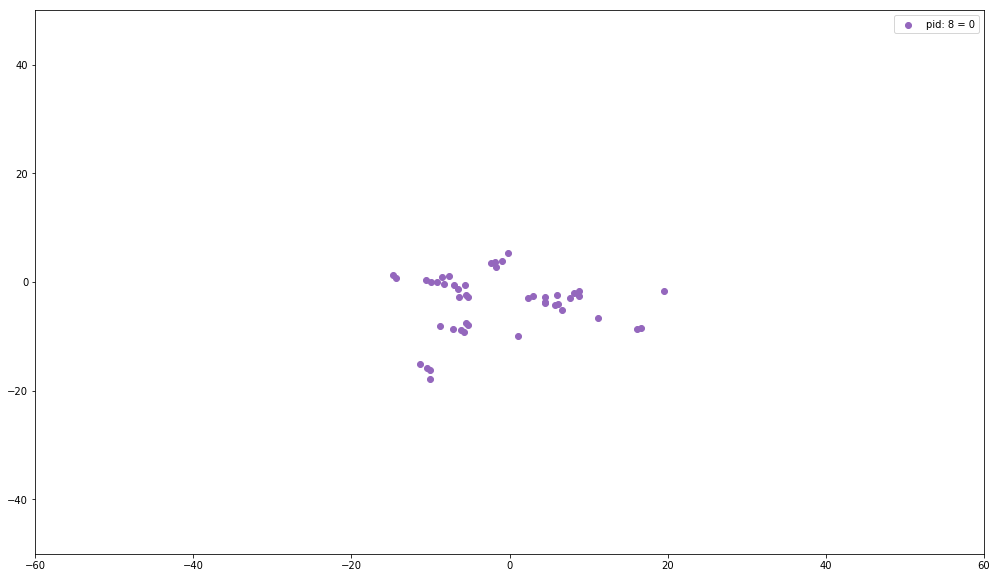

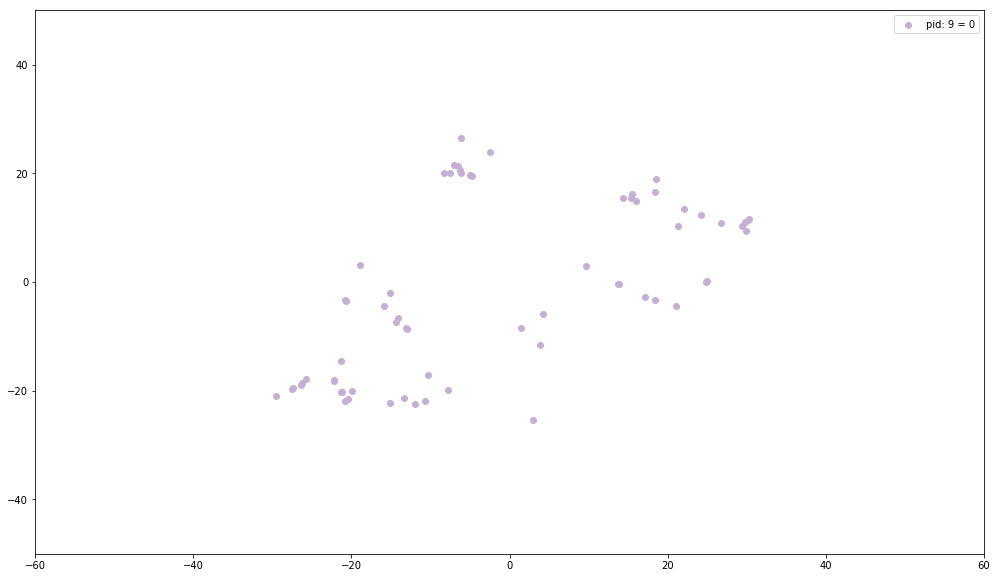

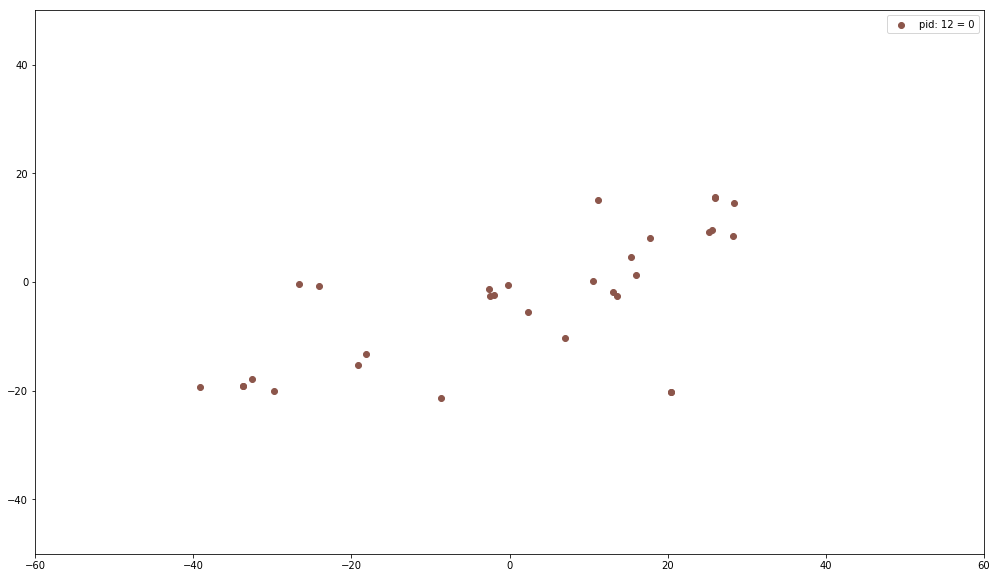

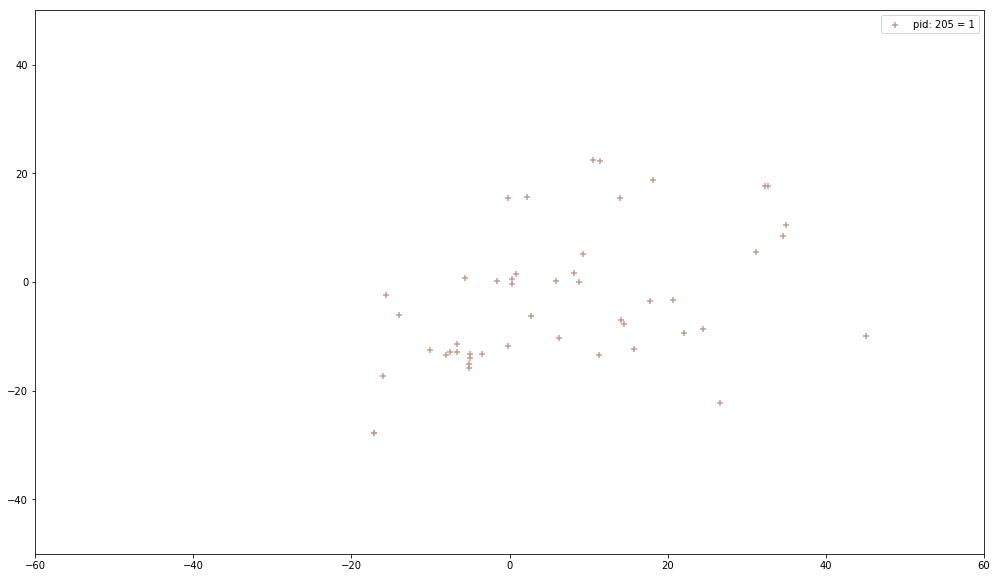

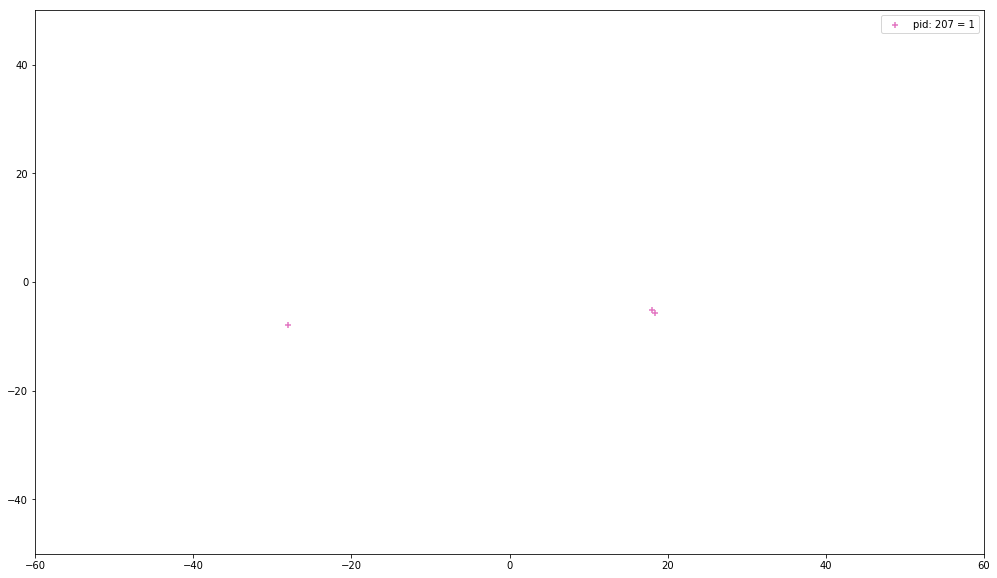

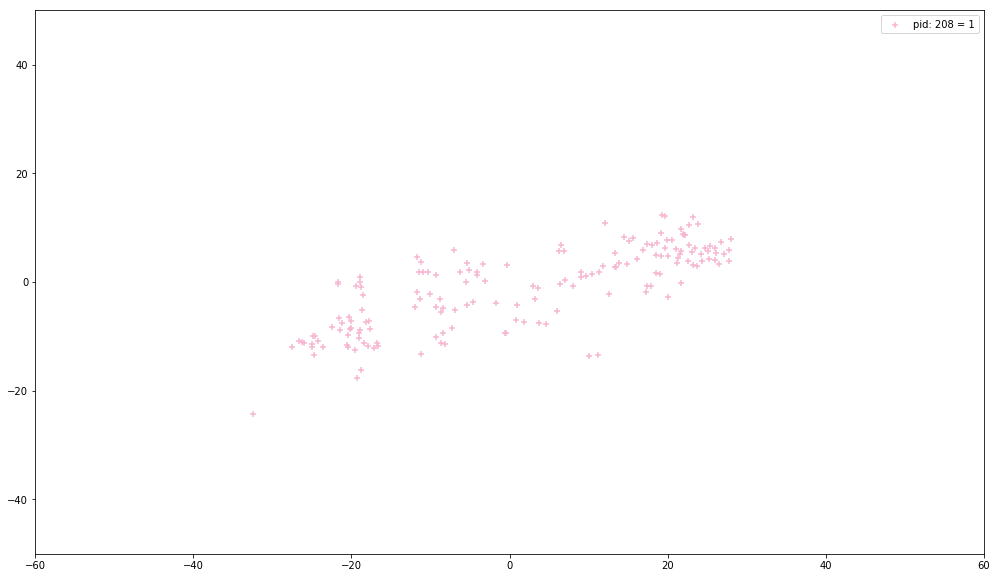

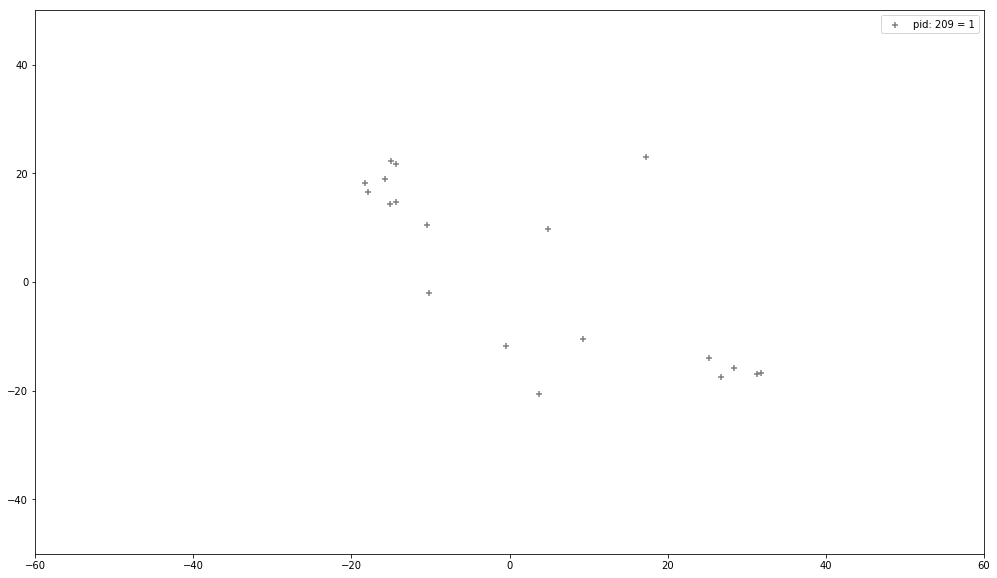

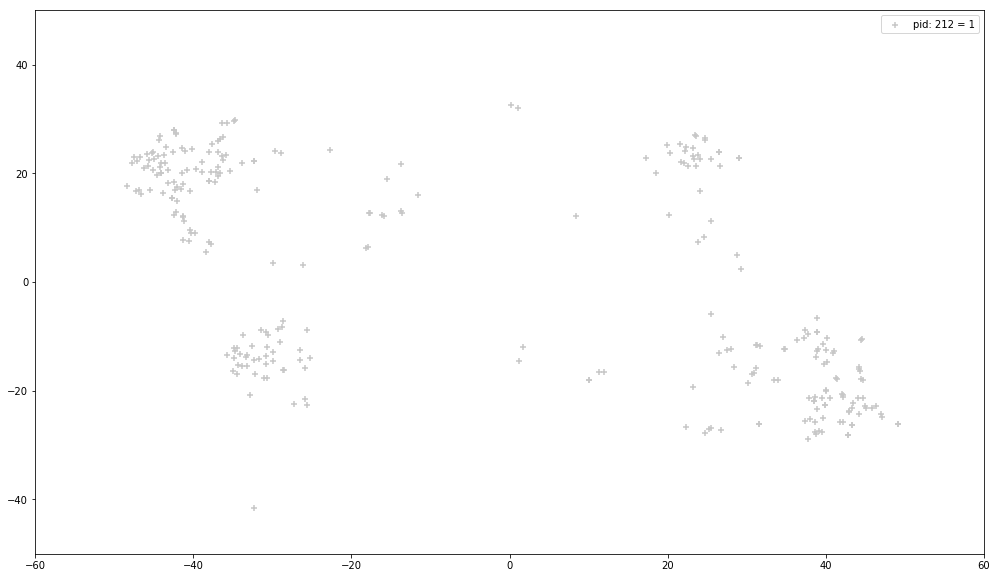

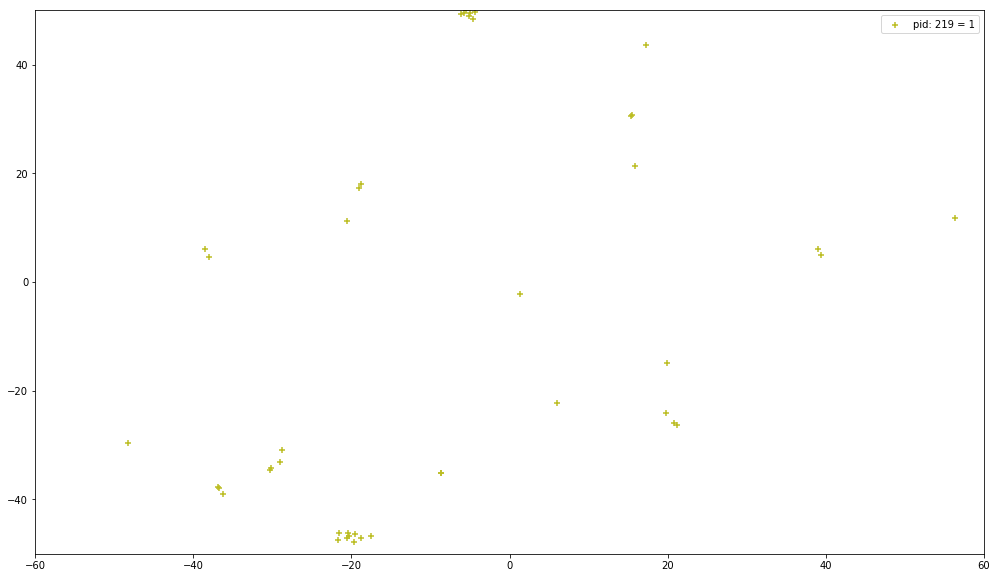

In [177]:
plt.rcParams['figure.figsize'] = (17, 10)
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab20')
markers = ['o','+']
for i, g in enumerate(np.unique(G)):
    a = X_codes_embedded[G == g]
    c = np.max(Y[G == g])
    plt.scatter(a[:,0], a[:,1], label = f'pid: {g:.0f} = {c}', c = [cmap.colors[i]], marker = markers[c])
    plt.legend()
    plt.ylim(-50,50)
    plt.xlim(-60,60)
    plt.show()

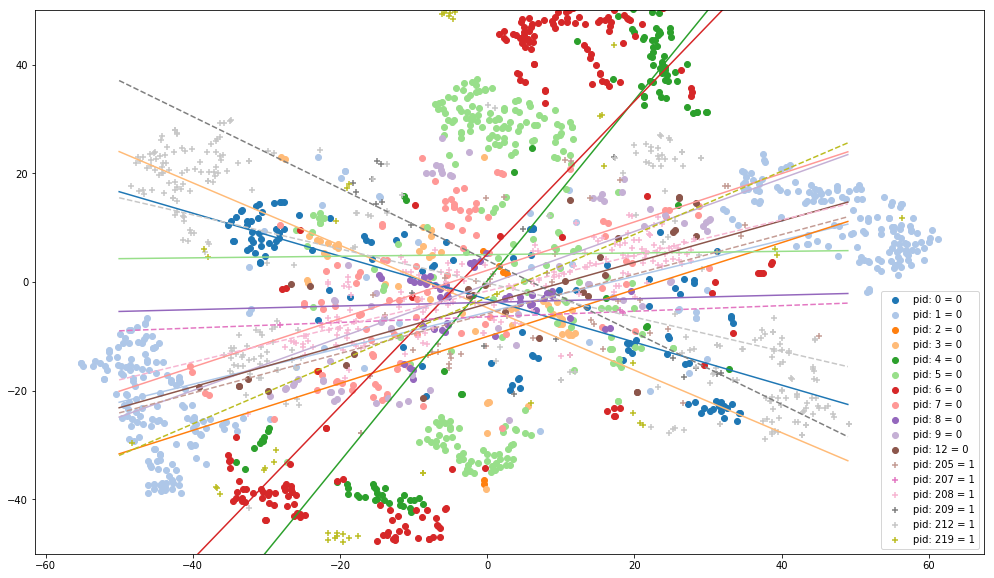

In [172]:
plt.rcParams['figure.figsize'] = (17, 10)
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab20')
markers = ['o','+']
linesty = ['-','--']
x_line = np.reshape(np.arange(-50,50,1),(100,1))
for i, g in enumerate(np.unique(G)):
    a = X_codes_embedded[G == g]
    c = np.max(Y[G == g])
    plt.scatter(a[:,0], a[:,1], label = f'pid: {g:.0f} = {c}', c = [cmap.colors[i]], marker = markers[c])
    clf = LinearRegression().fit(a[:,0][:,np.newaxis],a[:,1])
    y_line = clf.predict(x_line)
    plt.plot(x_line, y_line, linesty[c], c = cmap.colors[i])
plt.legend()
plt.ylim(-50,50)
plt.show()